# **Prediction of Heart Stroke**

---
In this analysis, we will explore the factors that influence stroke occurrences and employ machine learning techniques to predict stroke risks.

The dataset is taken from: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset  

Important questions?
*   What attributes are important for predicting a stroke?
*   Is Logistic Regression a good model for predicting a stroke from this dataset?



## **Importing necessary libraries**

In [121]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.preprocessing import (LabelEncoder, OneHotEncoder)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.datasets import make_imbalance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

## **Reading and exploring the dataset**

In [74]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [88]:
df = data.copy()

Since the 'id' variable is not required for further analysis, we are dropping that column.

In [89]:
df.drop('id', axis=1, inplace=True)

We can observe below that all the data columns contain 5110 observations except the 'bmi' column. We should handle these missing values later on.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


The below heatmap also shows that the 'bmi' variable has some missing data.

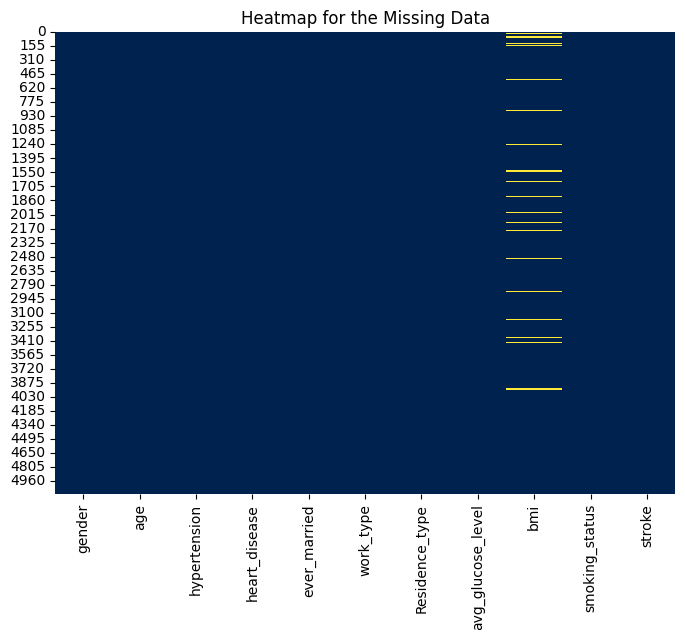

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [6]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.isnull(), cmap='cividis', cbar=False)
plt.title('Heatmap for the Missing Data')
plt.show()
df.isnull().sum()

We will use the describe method to look at the summary of descriptive statistics for our data, for both the numeric and non-numeric data. For instance, the non-numeric columns such as gender, ever_married, work_type, Residence_type and smoking_status will show the number of unique categories in each.

In [7]:
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [8]:
df.describe(include='object')

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,3,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2925,2596,1892


We can also check if there are any duplicate rows in our data.

In [5]:
df.duplicated().sum()

0

## **Exploratory Data Analysis (EDA)**

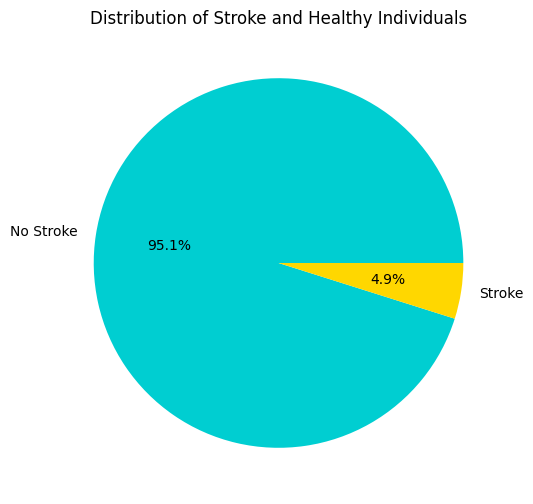

In [9]:
stroke_counts = df['stroke'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(stroke_counts, labels=['No Stroke', 'Stroke'], autopct='%1.1f%%', colors=['darkturquoise', 'gold'])
plt.title('Distribution of Stroke and Healthy Individuals')
plt.show()

In the above pie chart, the distribution of the 'No Stroke' and 'Stroke' data can be seen. The dataset class is highly imbalanced as the 'No Stroke' cases are in large numbers.

### **EDA - Gender**

<Figure size 1000x500 with 0 Axes>

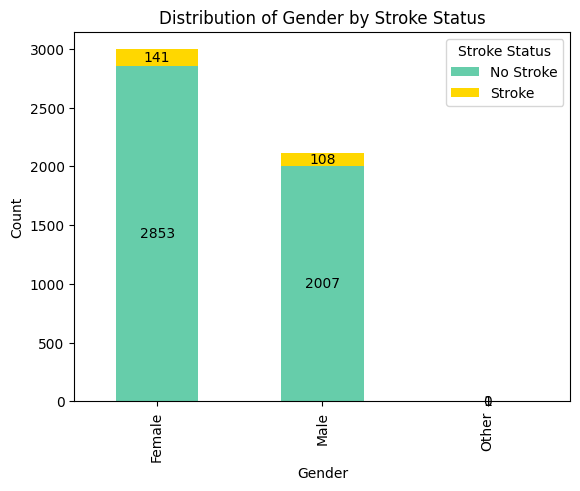

In [43]:
plt.figure(figsize=(10, 5))
ax = df.groupby(['gender', 'stroke']).size().unstack().plot(kind='bar', stacked=True, color=['mediumaquamarine', 'gold'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{int(height)}', ha='center', va='center')

plt.title('Distribution of Gender by Stroke Status')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Stroke Status', labels=['No Stroke', 'Stroke'])
plt.show()

The above bar plot shows the distribution of the gender column in the dataset. The 'Female' category has the majority representation, followed by 'Male' and 1 in 'Other'. Later on, we will handle the 'Other' category since it is unknown.

In [6]:
gender_stroke_counts = df.groupby(['gender', 'stroke']).size().unstack()
gender_stroke_percentage = (gender_stroke_counts[1] / (gender_stroke_counts[0] + gender_stroke_counts[1])) * 100

fig = px.pie(names=gender_stroke_percentage.index, values=gender_stroke_percentage.values,
             title="Percentage of Stroke Cases by Gender",
             color_discrete_sequence=['steelblue', 'plum'])

fig.update_traces(textinfo="percent+label")
fig.show()

The above pie chart shows the distribution of the stroke cases across the gender categories. It is evident that though the male representation is low in the dataset, they have higher chances of having a stroke.

### **EDA - Age**

Since Age is a continuous variable, we will create different bins for different age groups.

<Figure size 1000x600 with 0 Axes>

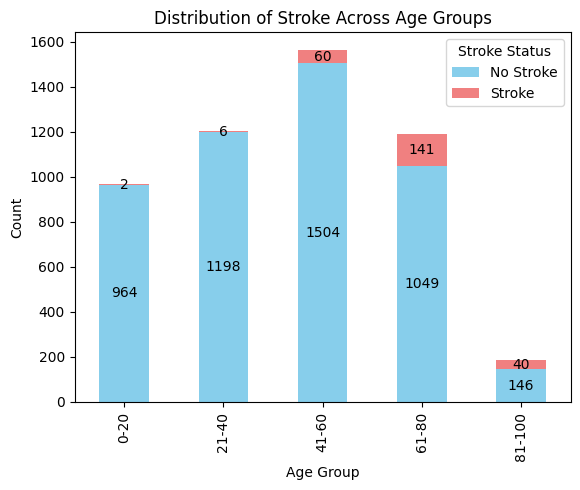

In [16]:
# Creating bins for age groups
bins = [0, 20, 40, 60, 80, 100]

# Creating labels for age group bins
labels = ['0-20', '21-40', '41-60', '61-80', '81-100']

plt.figure(figsize=(10, 6))
ax = df.groupby(pd.cut(df['age'], bins=bins, labels=labels, right=False))['stroke'].value_counts().unstack().plot(kind='bar', stacked=True, color=['skyblue', 'lightcoral'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{int(height)}', ha='center', va='center')

plt.title('Distribution of Stroke Across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Stroke Status', labels=['No Stroke', 'Stroke'])
plt.show()

The above plot shows that stroke probability increases with the age. There are a lot of stroke cases in the older population (60+ of age).

### **EDA - Hypertension**

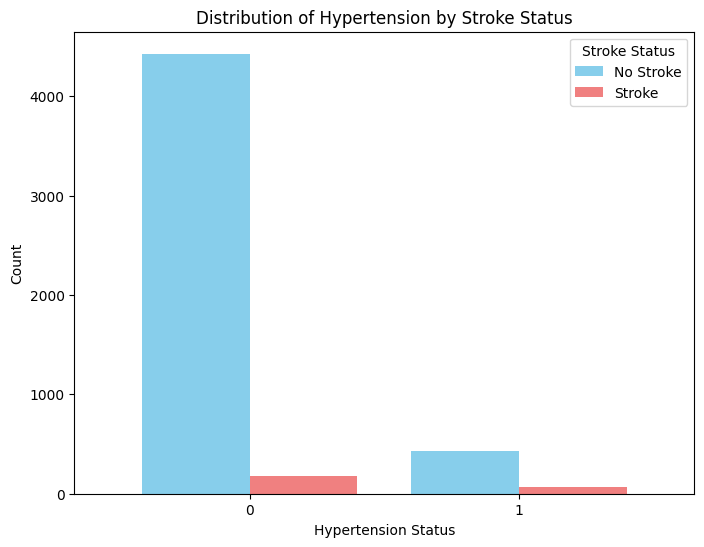

In [6]:
hypertension_stroke_counts = df.groupby(['hypertension', 'stroke']).size().unstack()

hypertension_stroke_counts.plot(kind='bar', color=['skyblue', 'lightcoral'], width=0.8, figsize=(8, 6))

plt.title('Distribution of Hypertension by Stroke Status')
plt.xlabel('Hypertension Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Stroke Status', labels=['No Stroke', 'Stroke'])

plt.show()


The 'No' hypertension category has majority representation in the data. The people with hypertension represent almost 10% of the population. The plot also shows the distribution of the stroke status within the hypertension variable.

The below graph demonstrates the percentage of people with or without hypertension who have a stroke.

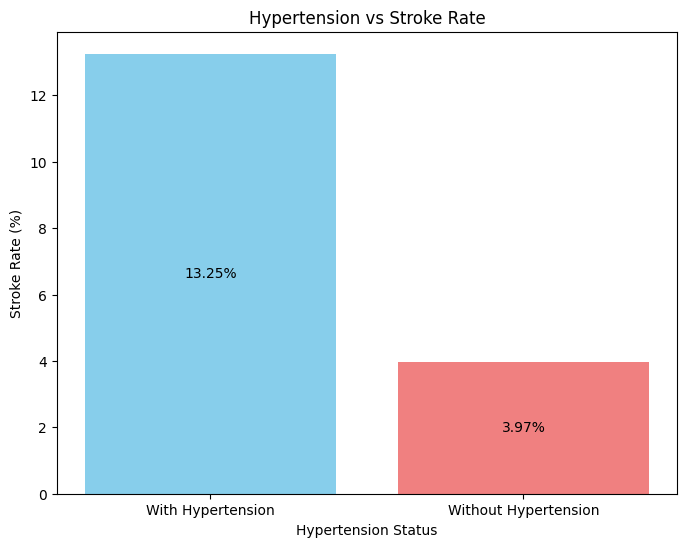

In [8]:
# Calculating stroke rates with and without hypertension
stroke_rate_with_hypertension = (df[df['hypertension'] == 1]['stroke'].mean()) * 100
stroke_rate_without_hypertension = (df[df['hypertension'] == 0]['stroke'].mean()) * 100

hypertension_labels = ['With Hypertension', 'Without Hypertension']
stroke_rates = [stroke_rate_with_hypertension, stroke_rate_without_hypertension]

fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(hypertension_labels, stroke_rates, color=['skyblue', 'lightcoral'])

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval / 2, f'{yval:.2f}%', ha='center', va='center', color='black')

plt.title('Hypertension vs Stroke Rate')
plt.xlabel('Hypertension Status')
plt.ylabel('Stroke Rate (%)')

plt.show()

### **EDA - Heart Disease**

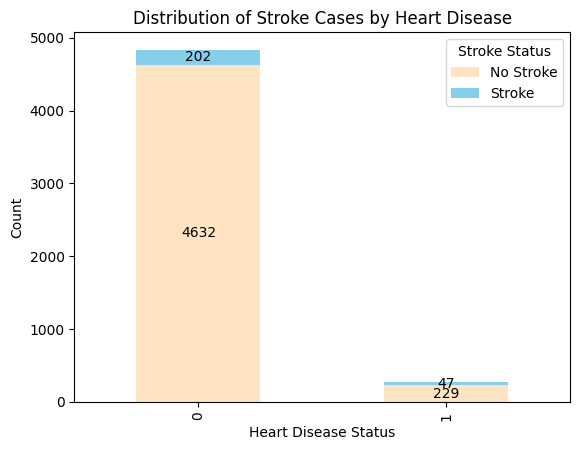

In [17]:
# Creating a contingency table
contingency_table = pd.crosstab(df['heart_disease'], df['stroke'])

fig, ax = plt.subplots()
bars = contingency_table.plot(kind='bar', stacked=True, ax=ax, color=['bisque', 'skyblue'])

plt.title('Distribution of Stroke Cases by Heart Disease')
plt.xlabel('Heart Disease Status')
plt.ylabel('Count')
plt.legend(title='Stroke Status', labels=['No Stroke', 'Stroke'])

for bar in bars.patches:
    x_pos = bar.get_x() + bar.get_width() / 2
    y_pos = bar.get_y() + bar.get_height() / 2
    value = int(bar.get_height())
    ax.text(x_pos, y_pos, f'{value}', ha='center', va='center', color='black')

plt.show()


The above stacked plot shows the distribution of stroke status across the heart disease category. The 'No' heart disease category has majority representation. Here, 4.17% of the people with no heart disease have a stroke and 17% of the people with heart disease have a stroke.

### **EDA - Marital Status**

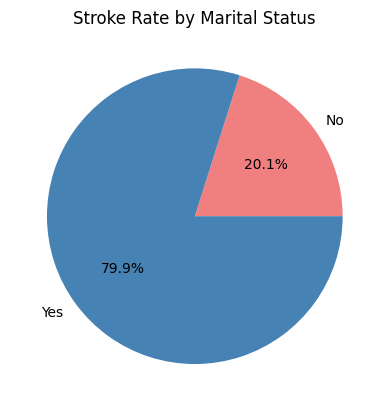

In [18]:
# Creating a contingency table for marital status and stroke
contingency_table = pd.crosstab(df['ever_married'], df['stroke'])

stroke_rate = (contingency_table[1] / (contingency_table[0] + contingency_table[1])) * 100

fig, ax = plt.subplots()
ax.pie(stroke_rate, labels=stroke_rate.index, autopct='%1.1f%%', colors=['lightcoral', 'steelblue'])

plt.title('Stroke Rate by Marital Status')

plt.show()


The above pie chart shows that people who are married have a relatively higher chances of having a stroke.

### **EDA - Work Type**

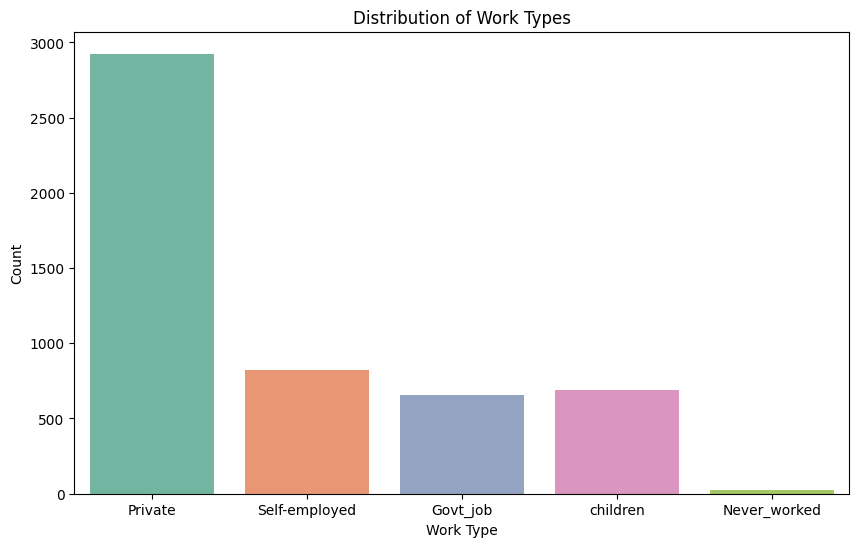

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='work_type', palette='Set2')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{int(height)}', ha='center', va='center')

plt.title('Distribution of Work Types')
plt.xlabel('Work Type')
plt.ylabel('Count')
plt.show()


The private job type has the highest representation in our dataset, followed by self-employed and govt jobs. Children also have a decent representation in the dataset.

In [21]:
work_stroke_rates = df.groupby("work_type")["stroke"].mean().reset_index()
colors = ['lightseagreen']

fig = px.bar(work_stroke_rates, x="work_type", y="stroke",
             title="Stroke Rate by Work Type",
             labels={"work_type": "Work Type", "stroke": "Stroke Rate"},
             color_discrete_sequence=colors)

fig.update_layout(xaxis_title="Work Type", yaxis_title="Stroke Rate")
fig.show()



The highest stroke rate is amongst the self-employed people, followed by govt job and private job.

### **EDA - Residence Type**

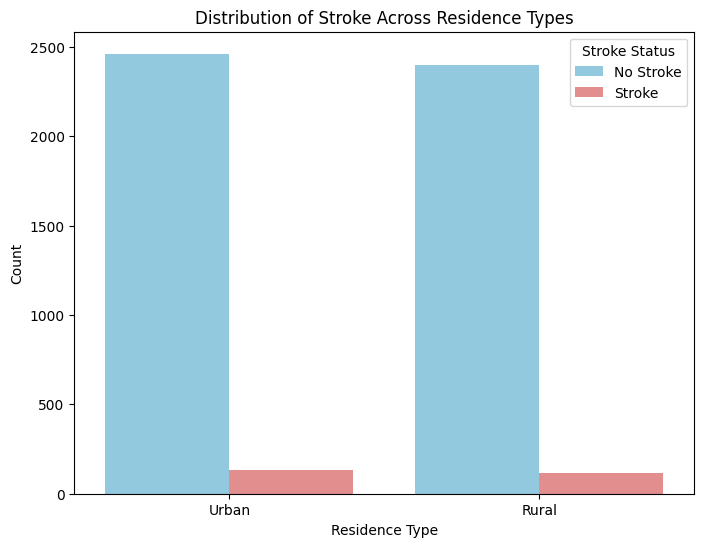

In [20]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Residence_type', hue='stroke', palette=['skyblue', 'lightcoral'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2, y + height / 2, f'{int(height)}', ha='center', va='center')

plt.title('Distribution of Stroke Across Residence Types')
plt.xlabel('Residence Type')
plt.ylabel('Count')
plt.legend(title='Stroke Status', labels=['No Stroke', 'Stroke'])
plt.show()


Both the 'urban' and 'rural' population has almost similar representation in our dataset.

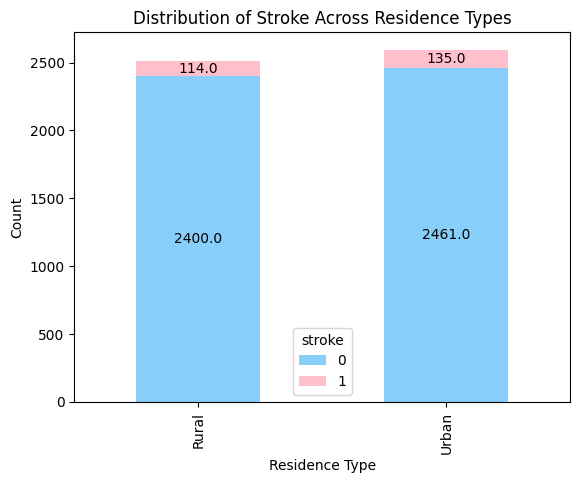

In [19]:
# Calculating the count of all samples for each residence type
residence_counts = pd.crosstab(df['Residence_type'], df['stroke'])

fig, ax = plt.subplots()

residence_counts.plot(kind='bar', stacked=True, color=['lightskyblue', 'pink'], ax=ax)

plt.title('Distribution of Stroke Across Residence Types')
plt.xlabel('Residence Type')
plt.ylabel('Count')

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height}', (x + width / 2, y + height / 2), ha='center', va='center')

plt.show()


Even the stroke rate does not differ very much in both the rural and urban population.

### **EDA - Average glucose levels**

Since avg_glucose_level is a continuous variable, I have created bins according to the medical diagnosis such as normal glucose level or diabetes.

In [24]:
# Creating glucose bins and labels
glucose_bins = [55.12, 70, 99, 125, 271.74]
glucose_labels = ['Low', 'Normal', 'Pre-Diabetes', 'Diabetes']

# Categorizing 'avg_glucose_level' into groups
df['avg_glucose_level_group'] = pd.cut(df['avg_glucose_level'], bins=glucose_bins, labels=glucose_labels, right=False)

fig = px.histogram(df, x='avg_glucose_level_group', color='stroke',
                   title='Distribution of Stroke Cases by Average Glucose Level Group',
                   labels={'avg_glucose_level_group': 'Average Glucose Level Group', 'stroke': 'Stroke'},
                   category_orders={'avg_glucose_level_group': glucose_labels},
                   color_discrete_sequence=['forestgreen', 'darksalmon'])

fig.update_layout(height=700, width=800)
fig.show()


The plot shows that diabetic people tend to have more chances of stroke.

### **EDA  - BMI**

I have categorized BMI variable into bins based on the BMI definitions.

In [25]:
df['stroke'] = df['stroke'].astype('category')

# Defining BMI bins and labels
bmi_bins = [10, 18.5, 24.9, 29.9, 34.9, 39.9, 50, float('inf')]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese Class I', 'Obese Class II', 'Obese Class III', 'Extreme Obesity']

# Categorizing 'bmi' into groups
df['bmi_group'] = pd.cut(df['bmi'], bins=bmi_bins, labels=bmi_labels, right=False)

bmi_stroke_counts = df.groupby(['bmi_group', 'stroke']).size().reset_index(name='Count')

fig = px.bar(bmi_stroke_counts, x='bmi_group', y='Count', color='stroke',
             title='Distribution of Strokes by BMI Group',
             labels={'bmi_group': 'BMI Group', 'Count': 'Count', 'stroke': 'Stroke'},
             color_discrete_sequence=['darkseagreen','slateblue'],
             text='Count')

fig.update_layout(xaxis_title='BMI Group', yaxis_title='Count', legend_title='Stroke')

fig.show()


The plot has a greater representation of overweight people, with the majority of the stroke cases.

### **EDA - Smoking status**

In [26]:
df['smoking_status'] = df['smoking_status'].astype('category')

smoking_stroke_counts = df.groupby(['smoking_status', 'stroke']).size().reset_index(name='Count')

fig = px.bar(smoking_stroke_counts, x='smoking_status', y='Count', color='stroke',
             title='Distribution of Strokes by Smoking Status',
             labels={'smoking_status': 'Smoking Status', 'Count': 'Count', 'stroke': 'Stroke'},
             color_discrete_sequence=['mediumseagreen', 'brown'],
             text='Count')  # Specify 'Count' as the text to be displayed on each bar

fig.update_layout(xaxis_title='Smoking Status', yaxis_title='Count', legend_title='Stroke')

fig.update_layout(height=700, width=800)
fig.show()


The population who have never smoked has majority representation and also has the highest stroke cases. We cannot comprehend much information from the above infograph.

## **P-value analysis for all the variables with the target variable (stroke)**

Here, we will do some statistical significance is assessed to determine whether there is a meaningful relationship between each independent variable and the target variable 'stroke'. The P-Value represents the probability of observing the observed results (or more extreme) under the assumption that the null hypothesis is true, where the null hypothesis typically states that there is no significant association between the variables.

A low P-Value (usually below a chosen significance level, 0.05) suggests that there is enough evidence to reject the null hypothesis, indicating a statistically significant relationship between the independent variable and the likelihood of experiencing a stroke. On the other hand, a high P-Value suggests a lack of evidence to reject the null hypothesis, implying a non-significant association.

I employed t-tests for continuous variables and chi-square tests for categorical variables. The choice of statistical tests depends on the nature of the variables being analyzed.

This analysis helps identify which variables have a statistically significant impact on the occurrence of strokes, providing valuable insights into potential predictors of stroke risk in the dataset.

### **Hypertension and Stroke**

In [34]:
# Creating a contingency table
contingency_table = pd.crosstab(df['hypertension'], df['stroke'])

# Performing chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f'Chi-squared statistic: {chi2}')
print(f'P-value: {p}')

alpha = 0.05

if p < alpha:
    print('Reject the null hypothesis. There is a significant association between hypertension and stroke.')
else:
    print('Fail to reject the null hypothesis. There is no significant association between hypertension and stroke.')


Chi-squared statistic: 81.6053682482931
P-value: 1.661621901511823e-19
Reject the null hypothesis. There is a significant association between hypertension and stroke.


### **Age and Stroke**

In [37]:
age_with_stroke = df[df['stroke'] == 1]['age'].dropna()
age_without_stroke = df[df['stroke'] == 0]['age'].dropna()

# Performing t-test
t_statistic, p_value = ttest_ind(age_with_stroke, age_without_stroke, equal_var=False)

print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

alpha = 0.05

if p_value < alpha:
    print('Reject the null hypothesis. There is a significant difference in age between those with and without stroke.')
else:
    print('Fail to reject the null hypothesis. There is no significant difference in age between those with and without stroke.')


T-statistic: 29.68626563006023
P-value: 2.115684848347272e-95
Reject the null hypothesis. There is a significant difference in age between those with and without stroke.


### **Residence type and Stroke**

In [39]:
# Creating a contingency table
contingency_table = pd.crosstab(df['Residence_type'], df['stroke'])

# Performing chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f'Chi-squared statistic: {chi2}')
print(f'P-value: {p}')

alpha = 0.05

if p < alpha:
    print('Reject the null hypothesis. There is a significant association between residence type and stroke.')
else:
    print('Fail to reject the null hypothesis. There is no significant association between residence type and stroke.')


Chi-squared statistic: 1.0816367471627524
P-value: 0.29833169286876987
Fail to reject the null hypothesis. There is no significant association between residence type and stroke.


### **Heart disease and Stroke**

In [40]:
# Creating a contingency table
contingency_table = pd.crosstab(df['heart_disease'], df['stroke'])

# Performing chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f'Chi-squared statistic: {chi2}')
print(f'P-value: {p}')

alpha = 0.05

if p < alpha:
    print('Reject the null hypothesis. There is a significant association between heart disease and stroke.')
else:
    print('Fail to reject the null hypothesis. There is no significant association between heart disease and stroke.')


Chi-squared statistic: 90.25956125843324
P-value: 2.0887845685229236e-21
Reject the null hypothesis. There is a significant association between heart disease and stroke.


### **Gender and Stroke**

In [41]:
# Creating a contingency table
contingency_table = pd.crosstab(df['gender'], df['stroke'])

# Performing chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f'Chi-squared statistic: {chi2}')
print(f'P-value: {p}')

alpha = 0.05

if p < alpha:
    print('Reject the null hypothesis. There is a significant association between gender and stroke.')
else:
    print('Fail to reject the null hypothesis. There is no significant association between gender and stroke.')


Chi-squared statistic: 0.47258662884530234
P-value: 0.7895490538408245
Fail to reject the null hypothesis. There is no significant association between gender and stroke.


### **Ever married and Stroke**

In [42]:
# Creating a contingency table
contingency_table = pd.crosstab(df['ever_married'], df['stroke'])

# Perform the chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square Value: {chi2}")
print(f"P-Value: {p}")

alpha = 0.05

if p < alpha:
    print("Reject the null hypothesis. There is a significant association between 'ever_married' and 'stroke'.")
else:
    print("Fail to reject the null hypothesis. There is no significant association between 'ever_married' and 'stroke'.")


Chi-Square Value: 58.923890259034195
P-Value: 1.6389021142314745e-14
Reject the null hypothesis. There is a significant association between 'ever_married' and 'stroke'.


### **Work type and Stroke**

In [43]:
# Creating a contingency table
contingency_table = pd.crosstab(df['work_type'], df['stroke'])

# Performing the chi-square test
chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square Value: {chi2}")
print(f"P-Value: {p}")

alpha = 0.05

if p < alpha:
    print("Reject the null hypothesis. There is a significant association between 'work_type' and 'stroke'.")
else:
    print("Fail to reject the null hypothesis. There is no significant association between 'work_type' and 'stroke'.")


Chi-Square Value: 49.163511976675295
P-Value: 5.397707801896119e-10
Reject the null hypothesis. There is a significant association between 'work_type' and 'stroke'.


### **Average glucose level and Stroke**

In [44]:
stroke_group = df[df['stroke'] == 1]['avg_glucose_level']
no_stroke_group = df[df['stroke'] == 0]['avg_glucose_level']

# Performing independent samples t-test
t_stat, p_value = ttest_ind(stroke_group, no_stroke_group, equal_var=False)

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in 'avg_glucose_level' between stroke and no stroke groups.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in 'avg_glucose_level' between stroke and no stroke groups.")


T-Statistic: 6.982411744792963
P-Value: 2.4014366563697676e-11
Reject the null hypothesis. There is a significant difference in 'avg_glucose_level' between stroke and no stroke groups.


### **BMI and Stroke**

In [45]:
# Separating data into two groups based on stroke status
stroke_group = df[df['stroke'] == 1]['bmi'].dropna()
no_stroke_group = df[df['stroke'] == 0]['bmi'].dropna()

# Performing t-test
t_stat, p_value = ttest_ind(stroke_group, no_stroke_group, equal_var=False)

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in 'bmi' between stroke and no stroke groups.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in 'bmi' between stroke and no stroke groups.")


T-Statistic: 3.6404100561556993
P-Value: 0.0003339710013121601
Reject the null hypothesis. There is a significant difference in 'bmi' between stroke and no stroke groups.


### **Smoking status and Stroke**

In [46]:
# Creating a contingency table
contingency_table = pd.crosstab(df['smoking_status'], df['stroke'])

# Performing chi-squared test
chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Squared Statistic: {chi2_stat}")
print(f"P-Value: {p_value}")

alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis. There is a significant association between 'smoking_status' and 'stroke'.")
else:
    print("Fail to reject the null hypothesis. There is no significant association between 'smoking_status' and 'stroke'.")


Chi-Squared Statistic: 29.147269191399264
P-Value: 2.0853997025008455e-06
Reject the null hypothesis. There is a significant association between 'smoking_status' and 'stroke'.


## **Data Pre-processing**

### **Handling Gender data column**
As we saw earlier in EDA, we have 3 categories of gender: male, female and other. The other only has 1 observation, so it would be better for our model to generalize over only two categories. I am randomly assigning the 'other' observation to any of the other two choices.

In [90]:
# Finding indices where gender is 'other'
other_indices = df[df['gender'] == 'Other'].index

# Replacing 'Other' with a random value from the existing sample
df.loc[other_indices, 'gender'] = np.random.choice(df['gender'].unique(), size=len(other_indices))

In [50]:
df.describe(include = "object")

,gender,ever_married,work_type,Residence_type,smoking_status
count,5110,5110,5110,5110,5110
unique,2,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2995,3353,2925,2596,1892


As we can see, now the gender column has only 2 categories.

### **Handling the missing values in the BMI data column**

Since, there were 201 missing values in the BMI data column, I will randomly fill those missing values with randomly chosen values from the existing data.

In [91]:
# Generating random indices for missing 'bmi' values
missing_bmi_indices = df[df['bmi'].isnull()].index

# Replacing missing 'bmi' values with random values from the existing data
df.loc[missing_bmi_indices, 'bmi'] = np.random.choice(df['bmi'].dropna(), size=len(missing_bmi_indices))

Visualizing the resampled BMI data column that comprises the existing data as well as the newly filled missing values.

In [92]:
df['stroke'] = df['stroke'].astype('category')

# Defining BMI bins and labels
bmi_bins = [10, 18.5, 24.9, 29.9, 34.9, 39.9, 50, float('inf')]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese Class I', 'Obese Class II', 'Obese Class III', 'Extreme Obesity']

bmi_stroke_counts = df.groupby([pd.cut(df['bmi'], bins=bmi_bins, labels=bmi_labels, right=False), 'stroke']).size().reset_index(name='Count')

fig = px.bar(bmi_stroke_counts, x='bmi', y='Count', color='stroke',
             title='Distribution of Strokes by BMI Group',
             labels={'bmi': 'BMI Group', 'Count': 'Count', 'stroke': 'Stroke'},
             color_discrete_sequence=['darkseagreen','slateblue'],
             text='Count')  # Specify 'Count' as the text to be displayed on each bar

fig.update_layout(xaxis_title='BMI Group', yaxis_title='Count', legend_title='Stroke')

fig.show()


### **Handling the categorical variables**
Based on the p-value, we will not be considering the 'gender' and 'residence_type' variables for our modeling. Hence, I will remove them.

Further, the 'ever_married' variable has binary categories, hence I will label encode it. The 'work_type' and 'smoking_status' have more than two categories, hence, it would be best to use one-hot encoding for them.

In [93]:
df = df.drop(['gender', 'Residence_type'], axis=1)

In [94]:
# Label encoding for 'ever_married'

label_encoder = LabelEncoder()

df['ever_married'] = label_encoder.fit_transform(df['ever_married'])

In [95]:
# One-hot encoding for 'work_type' and 'smoking_status'

df = pd.get_dummies(df, columns=['work_type', 'smoking_status'], drop_first=True)

df.head()

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,1,228.69,36.6,1,0,1,0,0,1,0,0
1,61.0,0,0,1,202.21,26.1,1,0,0,1,0,0,1,0
2,80.0,0,1,1,105.92,32.5,1,0,1,0,0,0,1,0
3,49.0,0,0,1,171.23,34.4,1,0,1,0,0,0,0,1
4,79.0,1,0,1,174.12,24.0,1,0,0,1,0,0,1,0


## **Data Modeling using Logistic Regression**

I will use the Synthetic Minority Over-sampling Technique (SMOTE) to address the class imbalance in the target variable, 'stroke'.

*   I will separate the features (X) and the target variable (y).
*   Then, split the data into training and testing sets to assess the model's performance on unseen data.
*   The SMOTE technique is then to be applied to the training data (X_train, y_train). This oversamples the minority class ('stroke' = 1) by generating synthetic examples.
*  Now, we have a new set of resampled data (X_resampled, y_resampled) that addresses the class imbalance issue.












### **SMOTE resampling**

In [104]:
X = df.drop('stroke', axis=1)  # Features
y = df['stroke']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

The new number of training samples is now 7802.

In [67]:
len(y_resampled)

7802

Below is a visualization of the stroke categories after applying SMOTE.

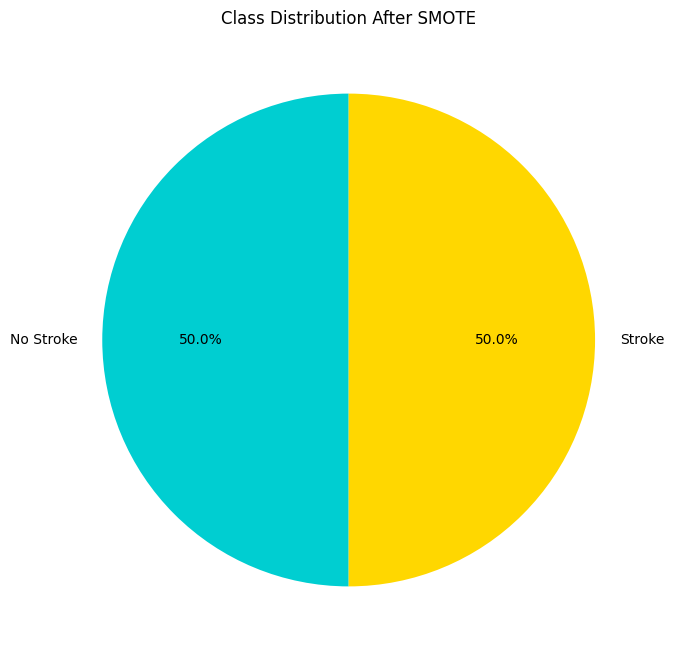

In [69]:
resampled_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='stroke')], axis=1)

stroke_distribution_after_smote = resampled_df['stroke'].value_counts().reset_index()
stroke_distribution_after_smote.columns = ['Stroke', 'Count']

stroke_distribution_after_smote['Stroke'] = stroke_distribution_after_smote['Stroke'].map({0: 'No Stroke', 1: 'Stroke'})

plt.figure(figsize=(8, 8))
plt.pie(stroke_distribution_after_smote['Count'], labels=stroke_distribution_after_smote['Stroke'], autopct='%1.1f%%',
        colors=['darkturquoise', 'gold'], startangle = 90.0)
plt.title('Class Distribution After SMOTE')
plt.show()

### **Logistic Regression**

In [118]:
# Initializing and fitting the logistic regression model

logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
logreg.fit(X_train, y_train)

# Making predictions on the test set
y_pred = logreg.predict(X_test)

# Evaluating the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7465753424657534

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.74      0.85       960
           1       0.17      0.81      0.28        62

    accuracy                           0.75      1022
   macro avg       0.58      0.77      0.56      1022
weighted avg       0.93      0.75      0.81      1022



The overall accuracy of the model is 74.6%.

The precision for the positive class is 17%. Thus, when the model predicts a positive case, it is correct only 17% of the time.

The precision for the negative class is 98%. Thus, the model is very good at correctly identifying instances that do not have a stroke.

Recall for the positive class is 81%. This implies that the model is capturing 81% of the actual stroke cases.

Recall for the negative class is 74%. This indicates that the model is capturing 74% of the instances correctly identified as not having a stroke.

We can also see a comprehensive summary in the below confusion matrix.

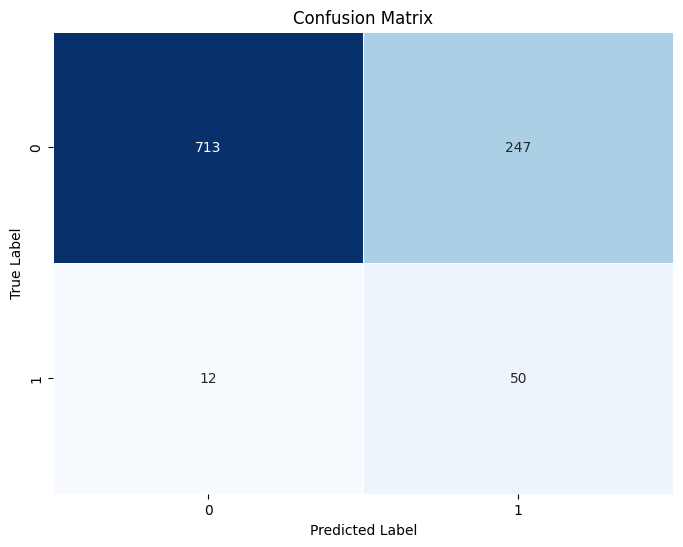

In [119]:
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=.5, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Below are the top predictive features based on the absolute magnitude of the logistic regression coefficients.

In [120]:
coefficients = logreg.coef_[0]
feature_names = X.columns

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

top_features = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

print("Top Predictive Features:")
print(top_features)


Top Predictive Features:
                           Feature  Coefficient
9               work_type_children     1.638920
1                     hypertension     0.511268
12           smoking_status_smokes     0.309842
3                     ever_married    -0.224313
2                    heart_disease     0.215532
11     smoking_status_never smoked    -0.180507
6           work_type_Never_worked    -0.180217
8          work_type_Self-employed    -0.148566
7                work_type_Private     0.146806
0                              age     0.081124
10  smoking_status_formerly smoked    -0.024189
5                              bmi     0.013605
4                avg_glucose_level     0.003974
